<a href="https://colab.research.google.com/github/ShaoFuLiu/tSDRG_DataAnalysis/blob/master/TestSortingData_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **tSDRG Data Analysis**

# **Import lib and set basic parameter**

In [2]:
## Import library
import os
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [15]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chocolate':            '#D2691E',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', 'x-', '^-', 's-', 'p-', '*-', 'h-']   ## marker array
spin = int(1)                                       ## Spin type
BC = 'PBC'
P = 10                                              ## Random distribution type (10 == Exponential distribution)
M = 30                                              ## Bound dimension 
font_size = 30

ALL_Dimer = ["Dim000","Dim001","Dim002","Dim003","Dim004","Dim005","Dim006","Dim008","Dim010"]
ALL_Jdis = ["Jdis000"]

Ddiff = 5
init_D = 10      ## Dim010 = 0.1
final_D = 100   ## Dim100 = 1.0
ds = (final_D - init_D)/Ddiff
for i in range (int(ds)):
    strD = "Dim00" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff >= 10):
        strD = "Dim0" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff >= 100):
        strD = "Dim" + str((i+1)*Ddiff+init_D)
    ALL_Dimer.append(strD)

Jdiff = 1
init_J = 1     ## Jdis001 = 0.01
final_J = 600   ## Jdis600 = 6.0
js = (final_J - init_J)/Jdiff
for i in range (int(js)+1):
    strJ = "Jdis00" + str((i+1)*Jdiff)
    if ((i+1)*Jdiff >= 10):
        strJ = "Jdis0" + str((i+1)*Jdiff)
    if ((i+1)*Jdiff >= 100):
        strJ = "Jdis" + str((i+1)*Jdiff)
    ALL_Jdis.append(strJ)

print(ALL_Dimer)
# print(ALL_Jdis)

['Dim000', 'Dim001', 'Dim002', 'Dim003', 'Dim004', 'Dim005', 'Dim006', 'Dim008', 'Dim010', 'Dim0015', 'Dim020', 'Dim025', 'Dim030', 'Dim035', 'Dim040', 'Dim045', 'Dim050', 'Dim055', 'Dim060', 'Dim065', 'Dim070', 'Dim075', 'Dim080', 'Dim085', 'Dim090', 'Dim095', 'Dim0100']


# **Start plot**

## Fix **<font color = red>J</font>**, look **<font color = green>L</font>**, **Order Parameter** vs **<font color = yellow>D</font>**, Multiplot

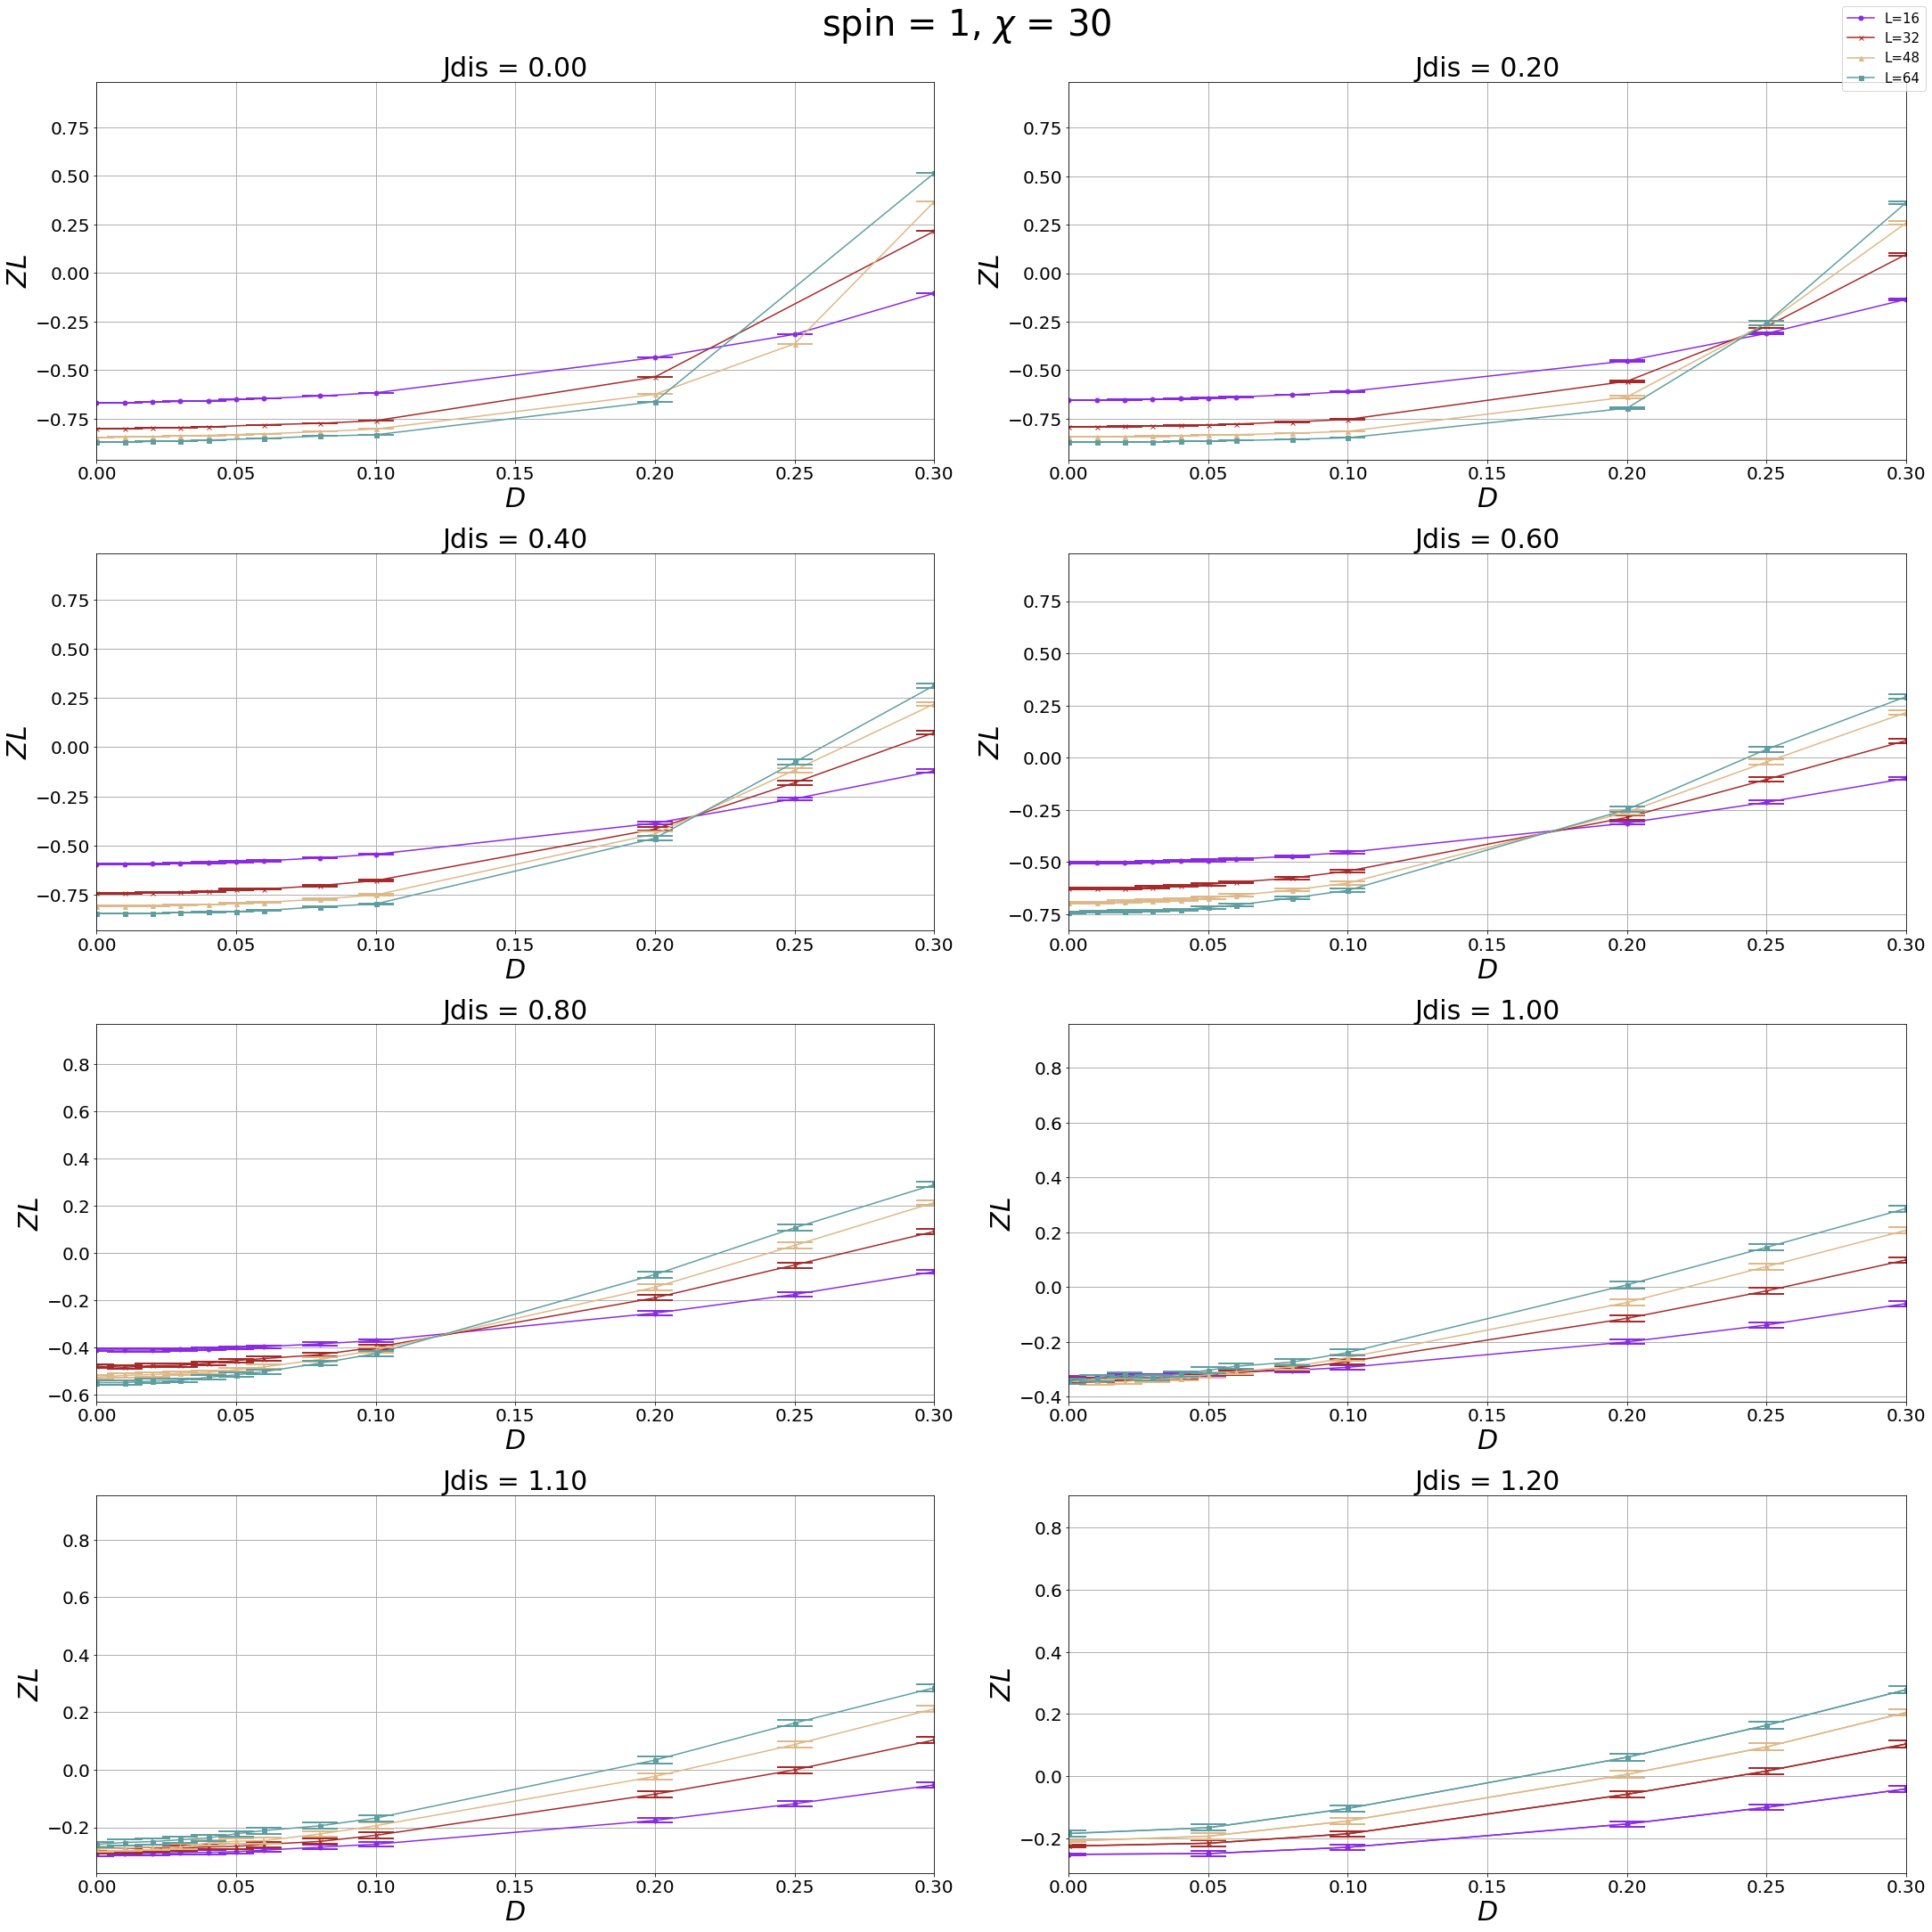

In [33]:
# 固定J, 看L, Order Parameter 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,32,48,64]               ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis000","Jdis020","Jdis040","Jdis060","Jdis080","Jdis100","Jdis110","Jdis120"]
# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.1])       #for SOP           
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.5])       #for SOP              
        ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.3])       #for ZL           
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.4, -0.2])       #for ZL 

        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()   

## Fix **<font color = yellow>D</font>**, look **<font color = green>L</font>**, **Order Parameter** vs **<font color = red>J</font>**, Multiplot

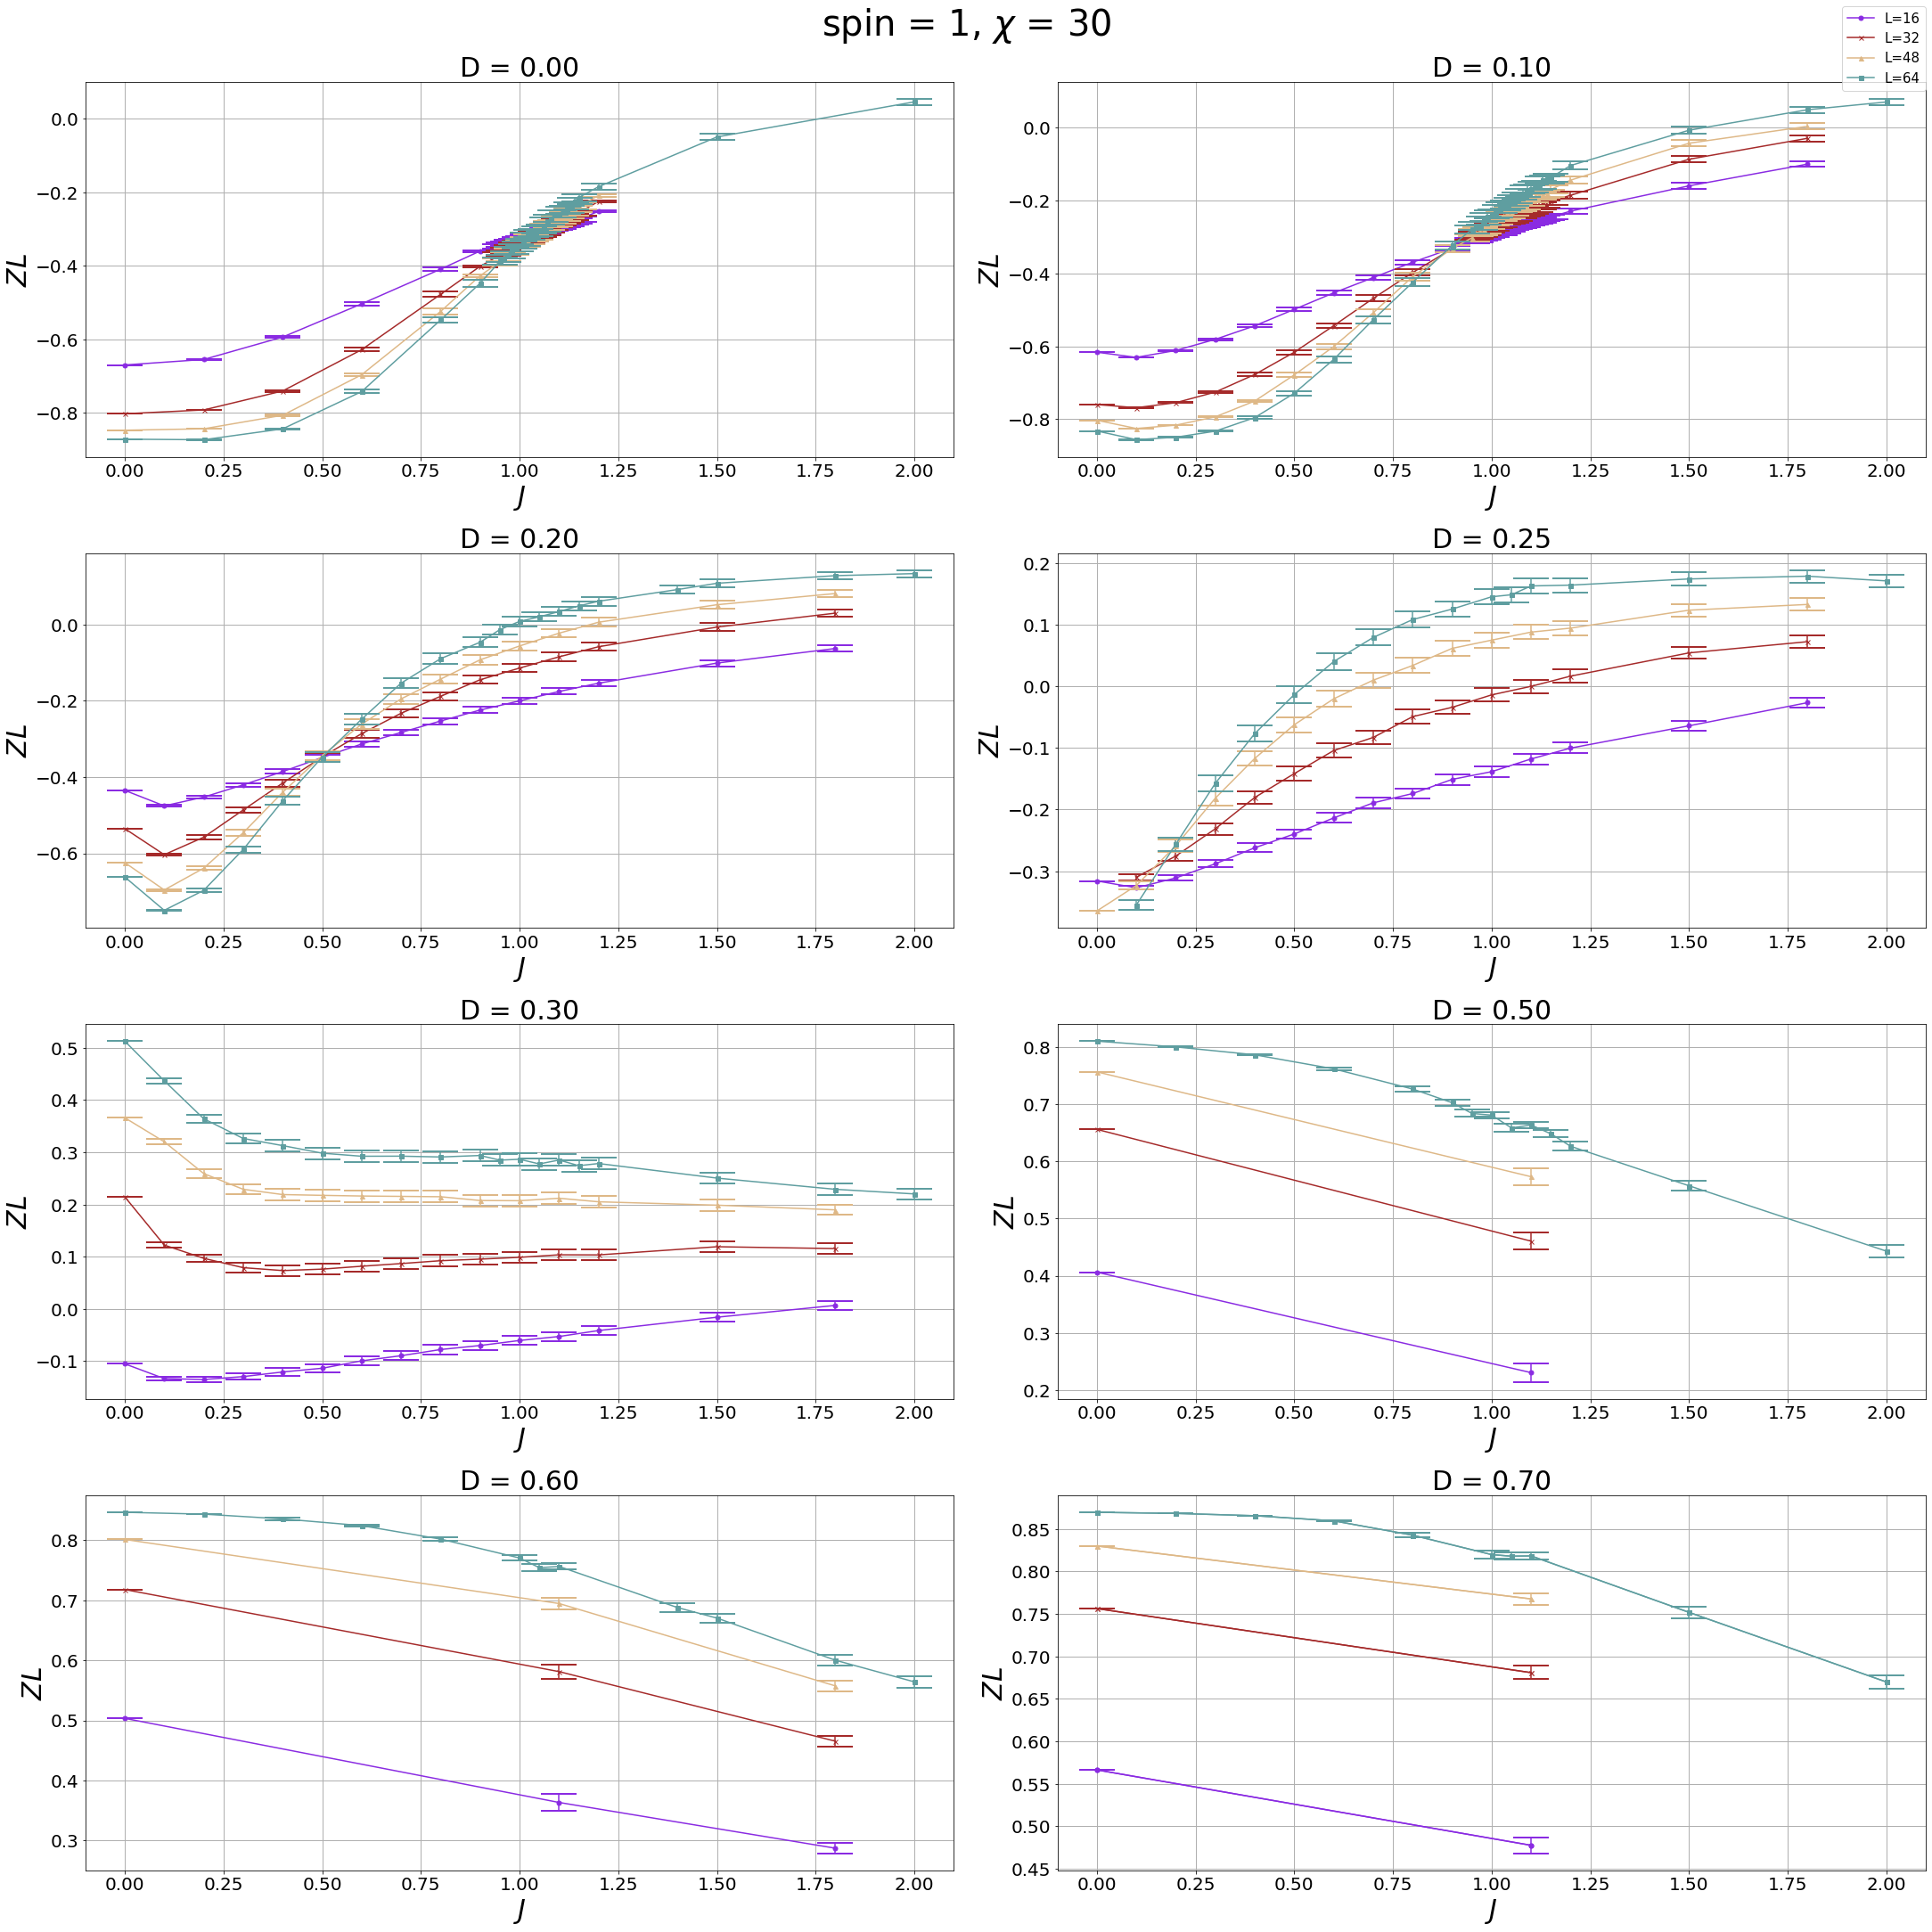

In [29]:
# 固定D, 看L, Order Parameter 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim000","Dim010","Dim020","Dim025","Dim030","Dim050","Dim060","Dim070"]
# Dimer = ["Dim000","Dim001","Dim080","Dim085","Dim095","Dim100","Dim105","Dim110"]
Jdis = ALL_Jdis
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15))
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)
            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0.95, 1.2])                    
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.4, -0.2])                      

        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

## Fix **<font color = green>L</font>**, look **<font color = red>J</font>**, **Order Parameter** vs **<font color = yellow>D</font>**

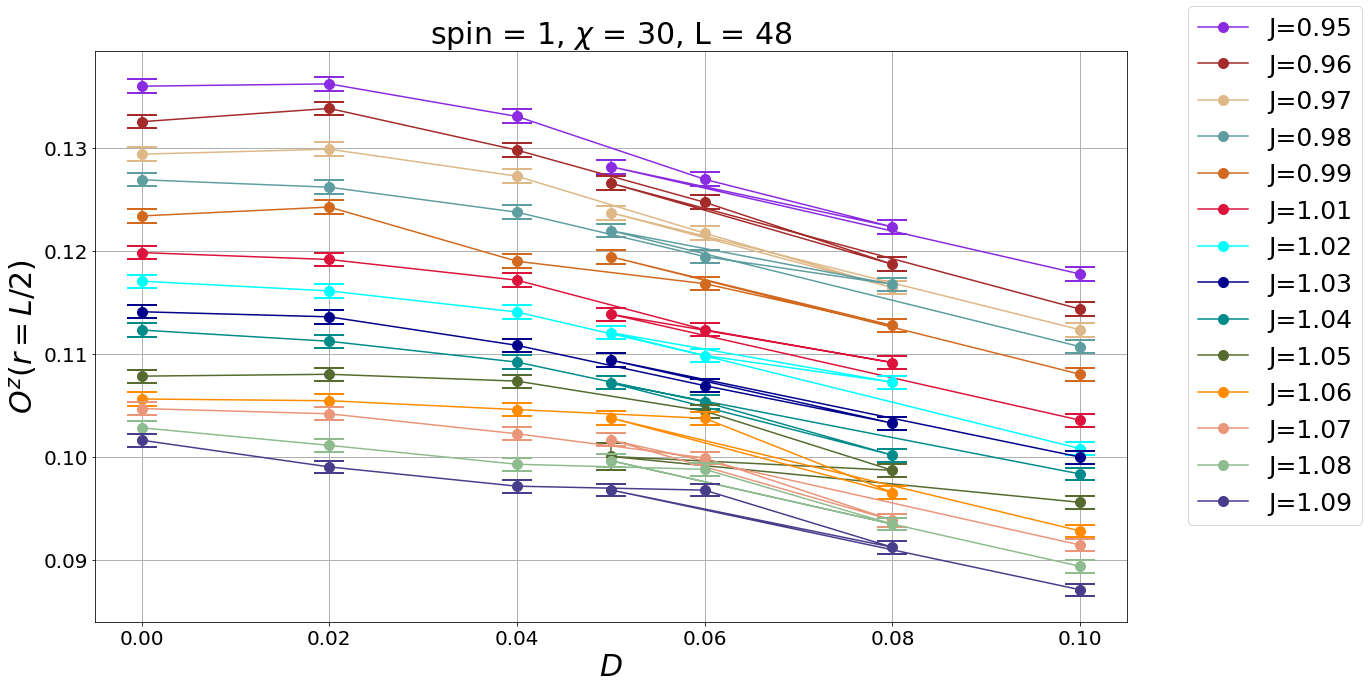

In [8]:
OrderPara = "SOP"   ## Choose SOP or ZL
Ls = [48]
Dimer = ALL_Dimer
# Dimer = ["Dim000"]
Jdis = ["Jdis095","Jdis096","Jdis097","Jdis098","Jdis099","Jdis101","Jdis102","Jdis103","Jdis104","Jdis105","Jdis106","Jdis107","Jdis108","Jdis109"]

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$', fontsize=font_size)
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]}
                
            dfplt.loc[d] = mean
         
        plt.plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l+j], markersize = font_size/3, label = 'J=%.2f' %(J))
        plt.errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[l+j], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$D$', fontsize=font_size)

# plt.xlim(0.9,1.2)
# plt.ylim(0, 0.1)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, L = %d' % (spin, M, L), fontsize=font_size)
plt.legend(bbox_to_anchor=(1.24, 1.1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = green>L</font>**, look **<font color = yellow>D</font>**, **Order Parameter** vs **<font color = red>J</font>**

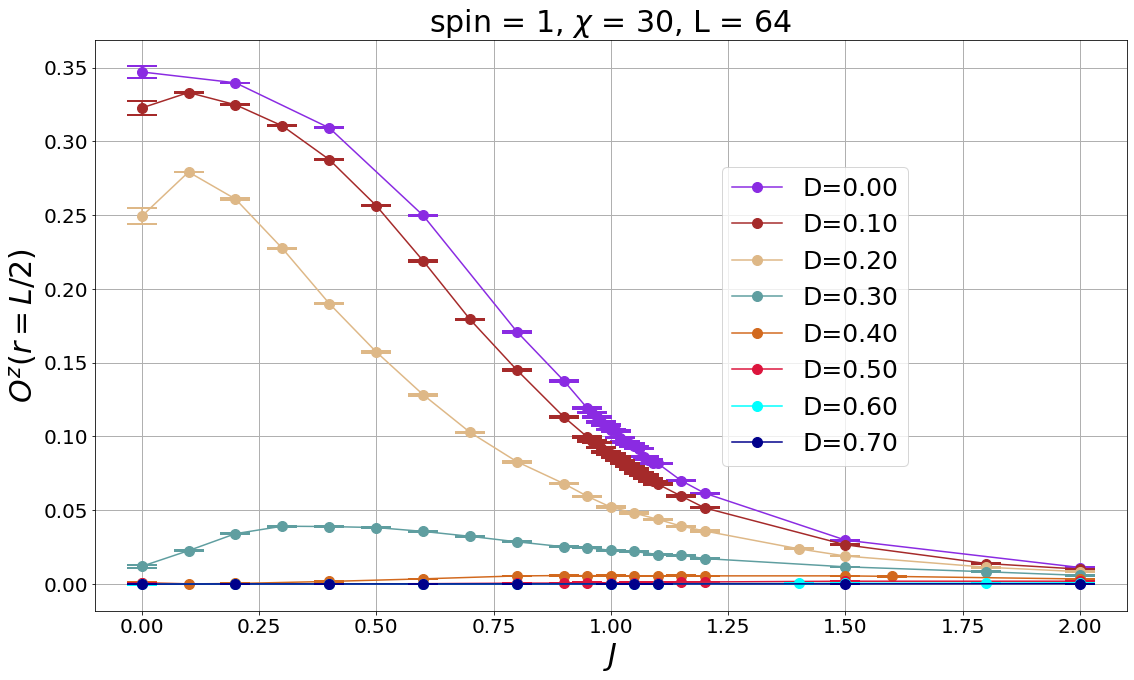

In [4]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [64]
Dimer = ["Dim000","Dim010","Dim020","Dim030","Dim040","Dim050","Dim060","Dim070"]
Jdis = ALL_Jdis

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
            
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[j] = mean

        plt.plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l+d], markersize = font_size/3, label = 'D=%.2f' %(D))
        plt.errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[l+d], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$J$', fontsize=font_size)
plt.ylabel(ylable, fontsize=font_size)
# plt.xlim(2.5,6)
# plt.ylim(0.0, 0.02)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, L = %d' % (spin, M, L), fontsize=font_size)
plt.legend(bbox_to_anchor=(0.8, 0.8), loc = 'best',fontsize=font_size*5/6)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = yellow>D</font>**, look **<font color = red>J</font>**, **Order Parameter** vs **<font color = green>L</font>** (2021/09/02)

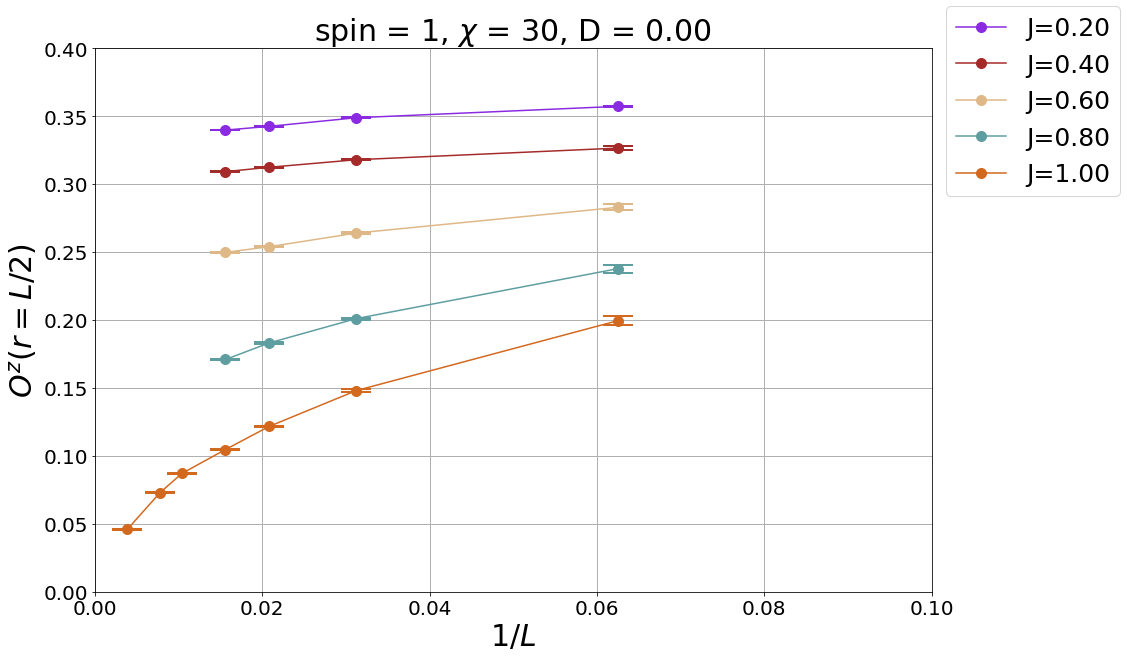

In [39]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16, 32, 48, 64, 96, 128, 256]
Dimer = ["Dim000"]
Jdis = ["Jdis020","Jdis040","Jdis060","Jdis080","Jdis100"]
# Jdis = ["Jdis000"]

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'


for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
    
    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['1/L', Para, 'error'])     
        
        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'1/L':1/L, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'1/L':1/L, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        plt.rcParams['figure.figsize'] = (15, 10)
        plt.plot(dfplt["1/L"], dfplt[Para], marr[d], color=carr[d+j], markersize = font_size/3, label = 'J=%.2f' %(J))
        plt.errorbar(dfplt["1/L"], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[d+j], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$1/L$', fontsize=font_size)
plt.ylabel(ylable, fontsize=font_size)
plt.xlim(0,0.1)
plt.ylim(0, 0.4)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, D = %.2f' % (spin, M, D), fontsize=font_size)
plt.legend(bbox_to_anchor=(1.24, 1.1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()